# Contextual Bandits Agent with Policy Gradient Method (Stochastic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import traceback
from tqdm.notebook import tnrange
from scipy.special import logit, expit
from PolicyGradientAgent import StochasticGradientAgent
from Environment import *

In [6]:
learning_rate_theta = 1e-4
learning_rate_wv = 0#1e-4
memory_size = 16
batch_size = 16
training_episodes = 900000
decay_rate = 0
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, regular
algorithm = 'regular'
learning_std = False
fixed_std = 0.3
# Bucket parameters
pr_red_ball_red_bucket = 2/3
pr_red_ball_blue_bucket = 1/3
prior_red_list = [3/4, 1/4]
agent_num=2
agent_list = []

for i in range(agent_num):
    agent = StochasticGradientAgent(feature_shape=[1, 3], learning_rate_theta=learning_rate_theta,
                                learning_rate_wv=learning_rate_wv, 
                                memory_size= memory_size, batch_size=batch_size,
                                beta1=beta1, beta2=beta2, 
                                learning_std=learning_std, fixed_std=fixed_std, name='agent' + str(i))
    agent_list.append(agent)
    agent.evaluation_init(pr_red_ball_red_bucket=pr_red_ball_red_bucket, pr_red_ball_blue_bucket=pr_red_ball_blue_bucket)


for t in tnrange(training_episodes):
    prior_red = np.random.choice(prior_red_list)
#     prior_red = np.random.uniform()
    bucket = Bucket(prior_red, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
    pm = PredictionMarket(prior_red=prior_red)
    
    for agent in agent_list:
        signal = bucket.signal()
        x = one_hot_encode(signal)
        x.append(logit(prior_red))
        h, mean, std = agent.report(x)
        pi = expit(h)
        report = [pi, 1 - pi]
        pm.report(report)
        R = pm.log_resolve(bucket_colour_to_num[bucket.colour])
        
        agent.store_experience(x, h, mean, std, R, t)
        try:
            agent.batch_update(t, algorithm= algorithm)
        except AssertionError:
            tb = traceback.format_exc()
            print(tb)
            
        agent.learning_rate_decay(epoch=t, decay_rate=decay_rate)
        prior_red = pi

  0%|          | 0/900000 [00:00<?, ?it/s]

agent0
learning_rate_theta= 0.0001  learning_rate_wv= 0
memory_size= 16  standard deviation= 0.3
Updating weights with regular algorithm.
agent1
learning_rate_theta= 0.0001  learning_rate_wv= 0
memory_size= 16  standard deviation= 0.3
Updating weights with regular algorithm.


In [11]:
reward_history_df = pd.DataFrame(agent.reward_history_list, columns=['signal', 'prior_red', 'actual_reward', 'estimated_average_reward'])
report_history_df = pd.DataFrame(agent.report_history_list, columns=['report', 'mean', 'std', 'signal'])
grad_mean_history_df = pd.DataFrame(agent.mean_gradients_history_list,
                                            columns=['red_ball', 'blue_ball', 'prior'])
mean_weights_history_df = pd.DataFrame(agent.mean_weights_history_list,
                                               columns=['red_weight', 'blue_weight', 'prior_weight'])

# reward_history_df2 = pd.DataFrame(agent2.reward_history_list, columns=['signal', 'prior_red', 'actual_reward', 'estimated_average_reward'])
# report_history_df2 = pd.DataFrame(agent2.report_history_list, columns=['report', 'mean', 'std', 'signal'])
# grad_mean_history_df2 = pd.DataFrame(agent2.mean_gradients_history_list,
#                                             columns=['red_ball', 'blue_ball', 'prior'])
# mean_weights_history_df2 = pd.DataFrame(agent2.mean_weights_history_list,
#                                                columns=['red_weight', 'blue_weight', 'prior_weight'])

# reward_history_df3 = pd.DataFrame(agent3.reward_history_list, columns=['signal', 'prior_red', 'actual_reward', 'estimated_average_reward'])
# report_history_df3 = pd.DataFrame(agent3.report_history_list, columns=['report', 'mean', 'std', 'signal'])
# grad_mean_history_df3 = pd.DataFrame(agent3.mean_gradients_history_list,
#                                             columns=['red_ball', 'blue_ball', 'prior'])
# mean_weights_history_df3 = pd.DataFrame(agent3.mean_weights_history_list,
#                                                columns=['red_weight', 'blue_weight', 'prior_weight'])

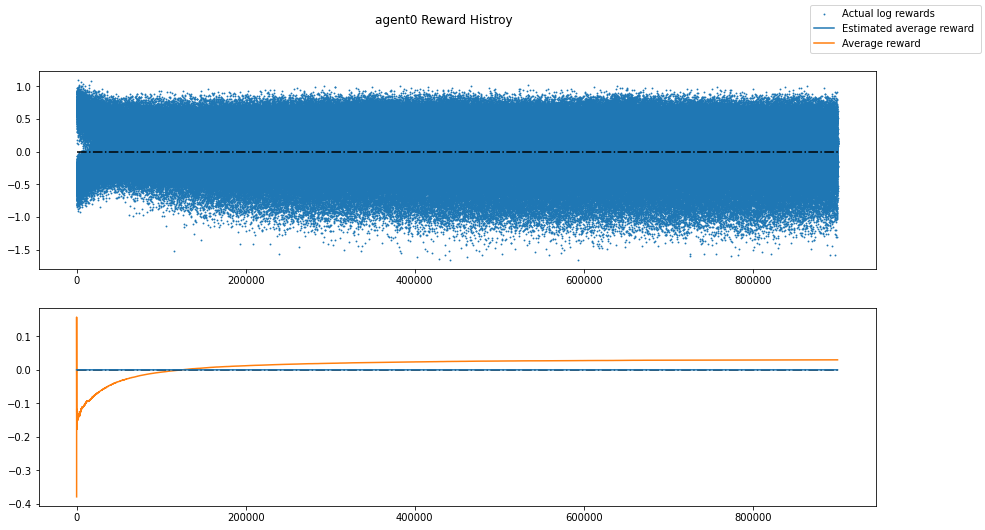

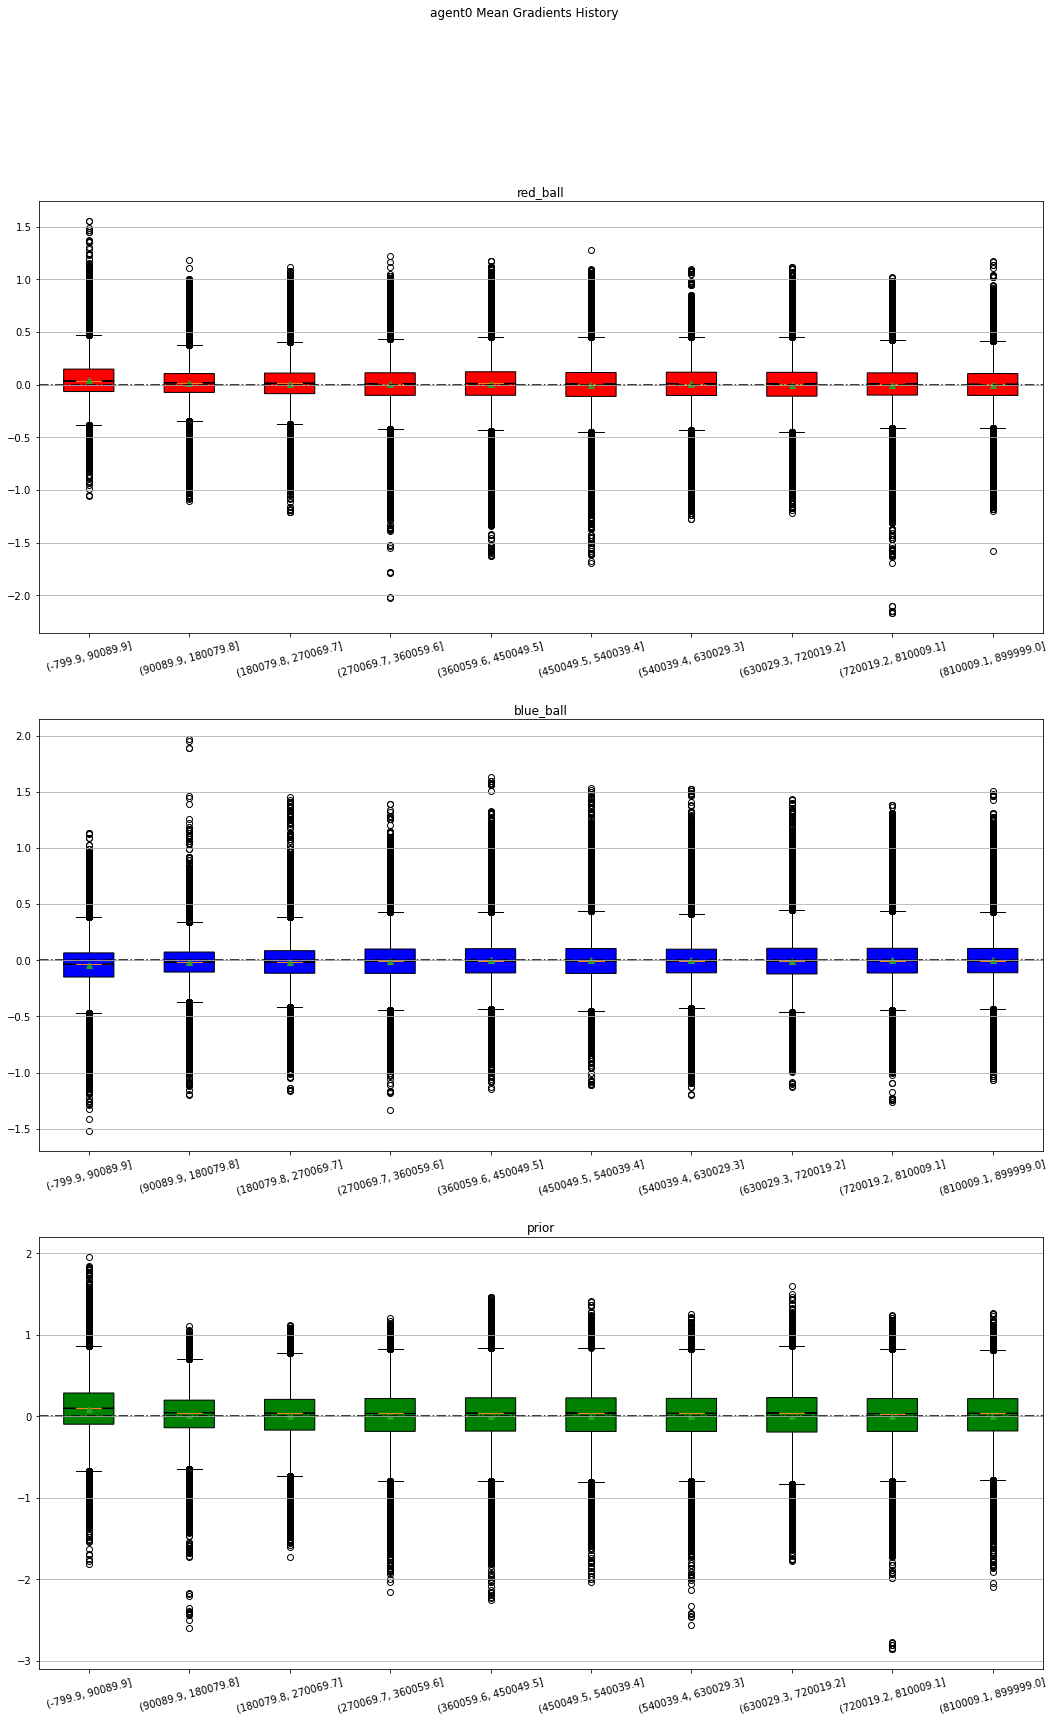

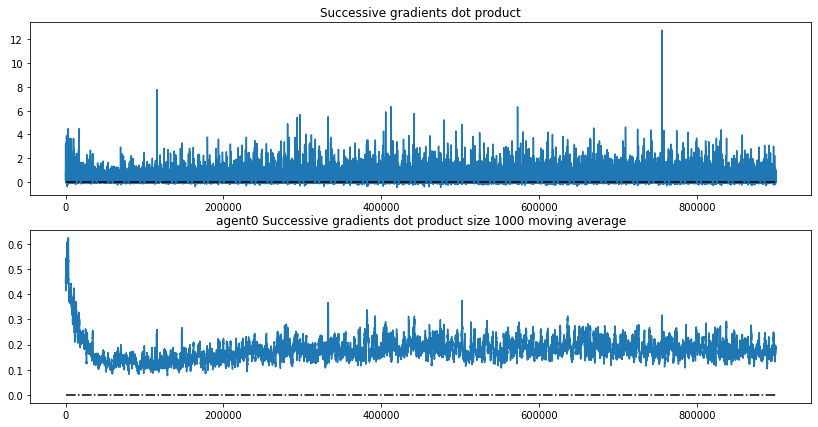

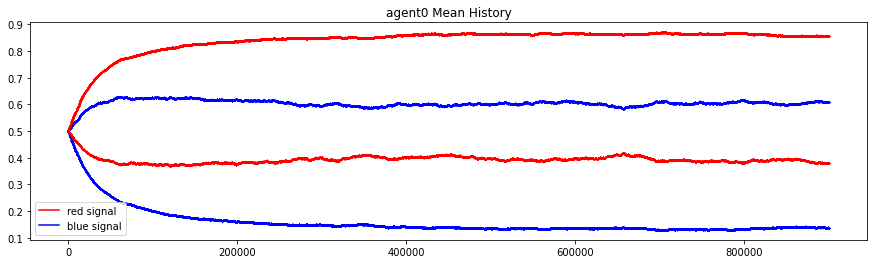

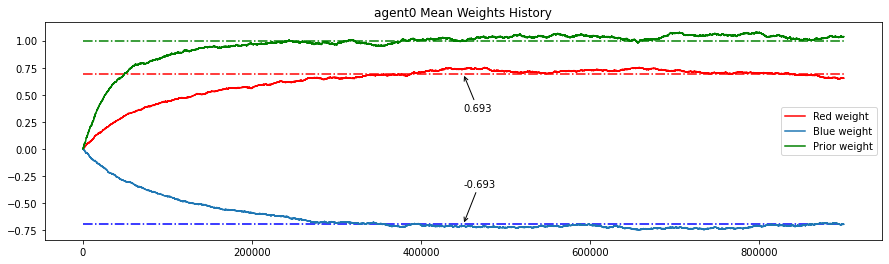

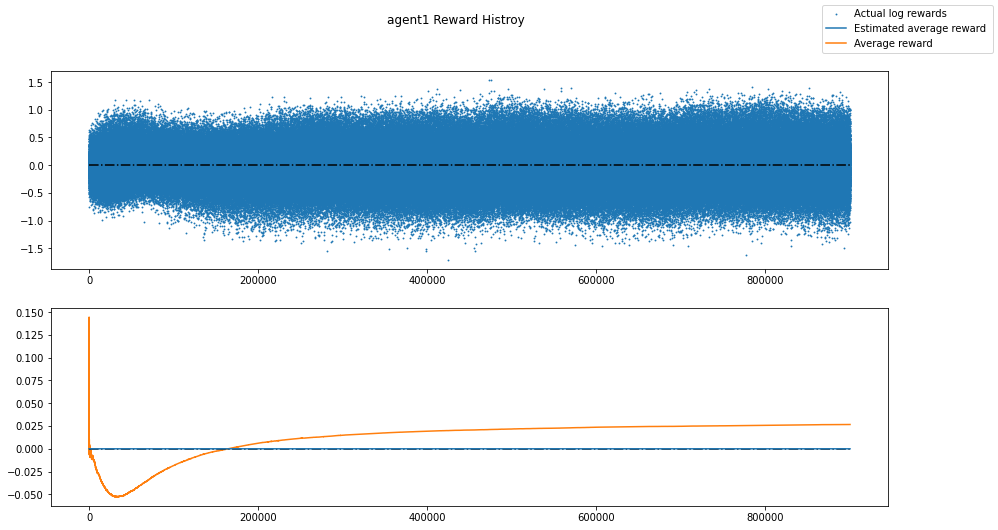

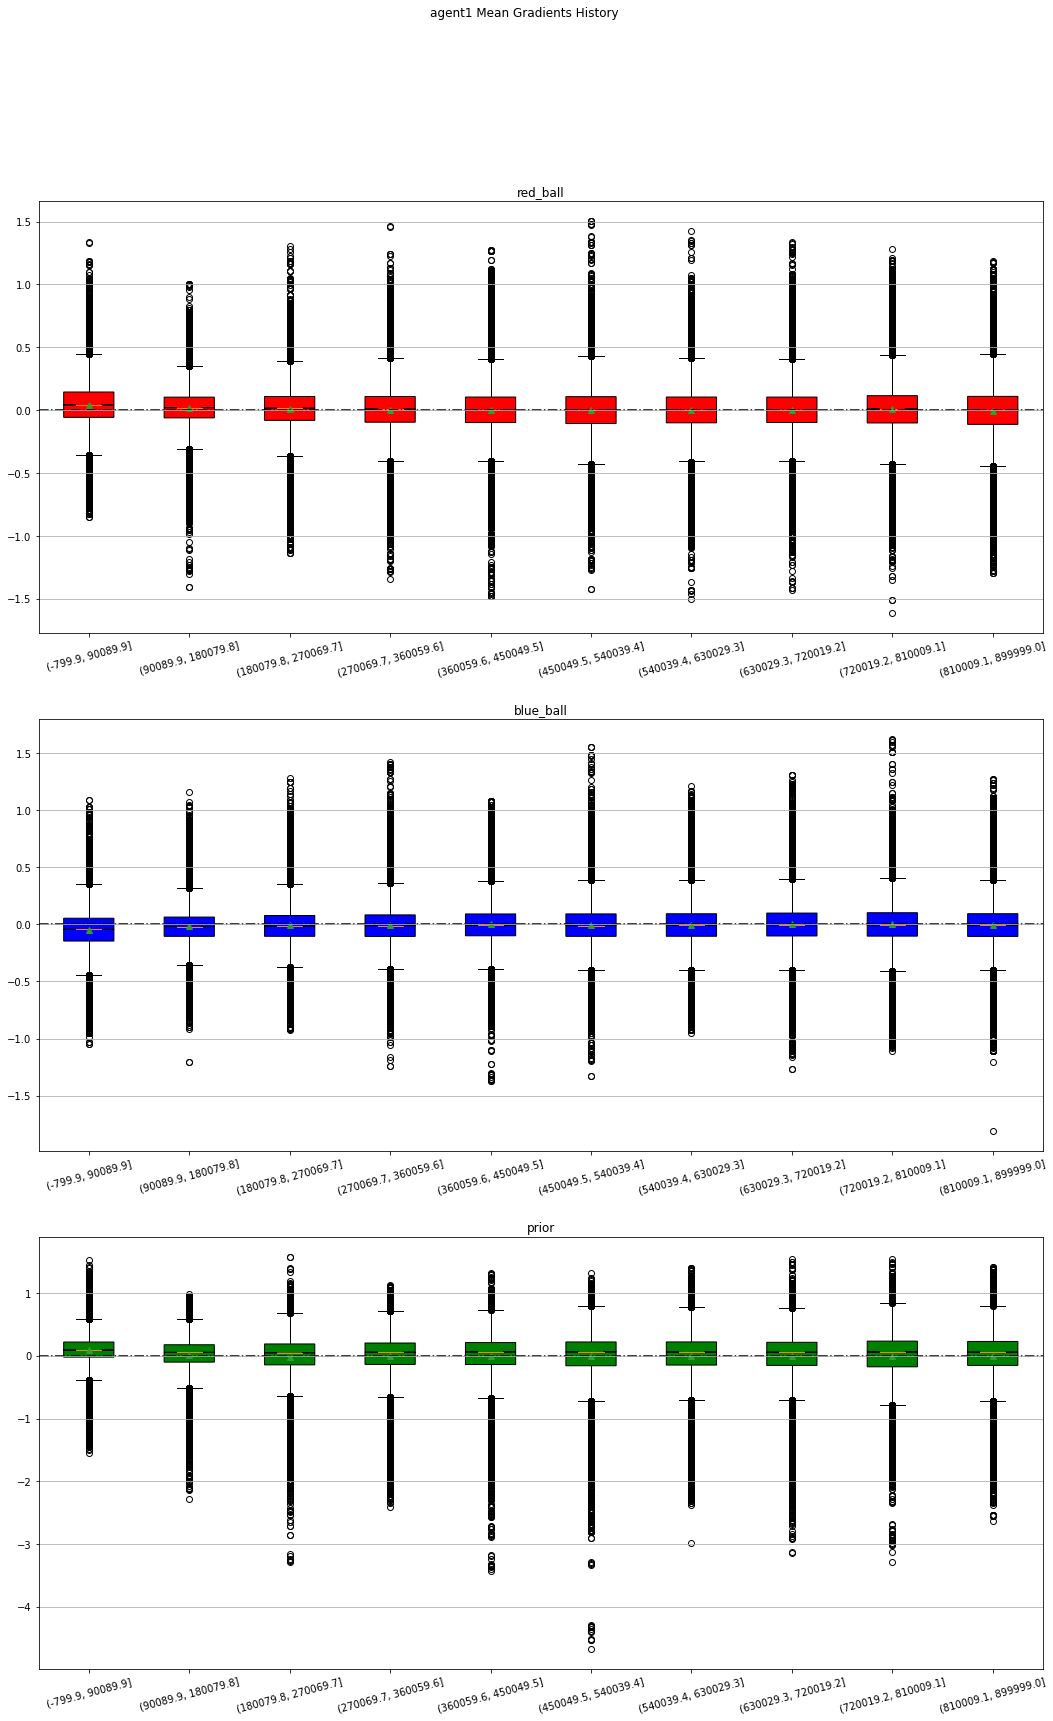

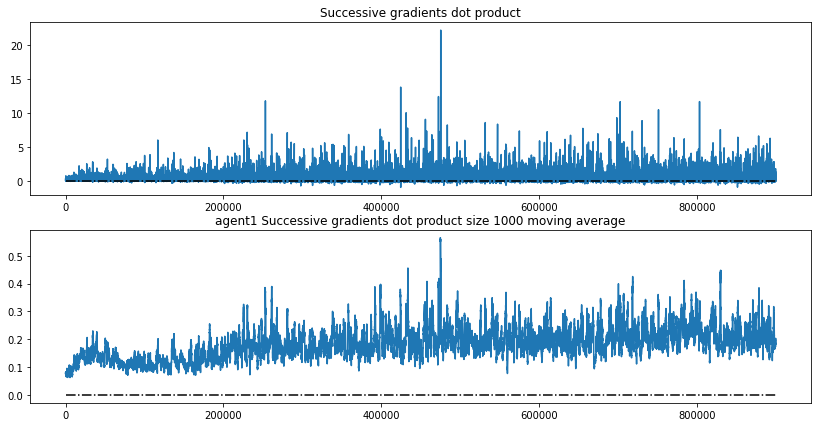

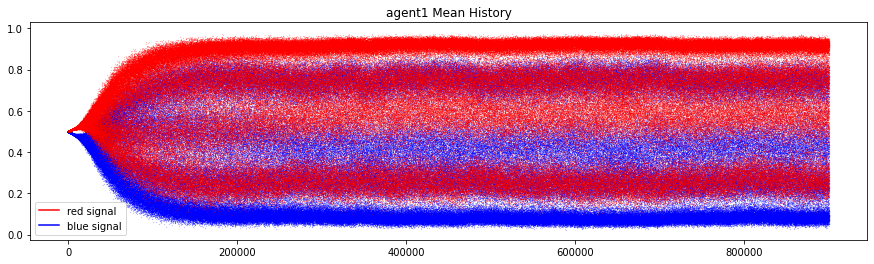

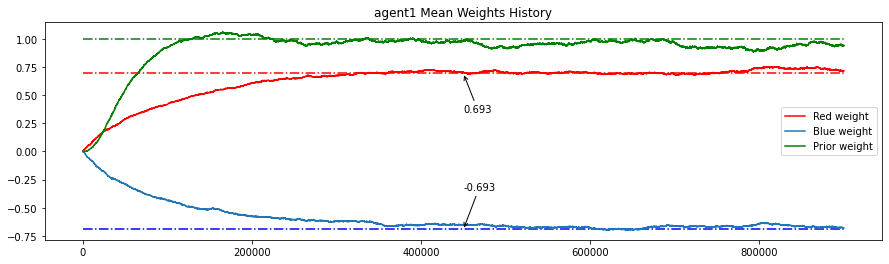

In [10]:
for agent in agent_list:
    agent.reward_history_plot()
#     agent.report_history_plot()
    agent.mean_gradients_history_plot()
    agent.mean_gradients_successive_dot_product_plot()
    agent.mean_history_plot()
    agent.mean_weights_history_plot()

In [ ]:
if learning_std:
    min_std = report_history_df['std'].min()
    fig, ax = plt.subplots(figsize=(15, 4))
    for signal, df in report_history_df.reset_index().groupby('signal'):
        ax.scatter(x=df['index'], y=df['std'], label=signal, marker='.', c=signal, s=0.1)
    plt.hlines(y=0, xmin=0, xmax=len(report_history_df) , colors='black', linestyles='dashdot')
    plt.hlines(y=min_std, xmin=0, xmax=len(report_history_df) , colors='black', linestyles='dashdot', label=str(min_std))
    red_line = mlines.Line2D([], [], color='red', label='red signal')
    blue_line = mlines.Line2D([], [], color='blue', label='blue signal')
    ax.legend(handles=[red_line, blue_line])
    plt.title('Standard Diviation')
